# Train and evaluate Kan models

In [3]:
# === Path and system setup ===
from pathlib import Path
import sys

# === Step 1: Manually set project root ===
PROJECT_ROOT = Path().resolve().parents[0]

# === Step 2: Add project root to sys.path if not already present ===
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# === Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
from matplotlib import rc

from datetime import datetime, timedelta

import torch
# from kan import KAN, create_dataset
from kan import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# === Project imports ===
from scripts.plot_setup import configure_plots

# === Plotting configuration ===
_ = configure_plots()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# Load processed data

path2file = Path('data/processed')

filename = Path('clean_filtered_pond_iot_2023.csv')

df_WQ = pd.read_csv(PROJECT_ROOT /path2file / filename)
df_WQ.head()

,Unnamed: 0,created_date,water_pH,TDS,water_temp,WA_WQI
0,0,2023-01-30 12:00:00,6.448000,287.600000,23.88,12.215376
1,1,2023-01-30 12:01:00,6.444373,287.614667,23.88,12.152570
2,2,2023-01-30 12:02:00,6.446986,287.622373,23.88,12.197797
3,3,2023-01-30 12:03:00,6.445146,290.989926,23.88,12.162970
4,4,2023-01-30 12:04:00,6.439843,290.930127,23.88,12.071205


In [5]:
# -----------------------------------------------------------
# 📊 Extract Input and Output Data for Symbolic Regression
# -----------------------------------------------------------

# 🔹 Input Variables (features):
# Select the columns to be used as predictors for WQI
# These represent environmental water quality measurements
xData = df_WQ[['water_pH', 'water_temp', 'TDS']].values

# 🔹 Output Variable (target):
# The Weighted Arithmetic Water Quality Index (WAWQI)
# This is the value we want to model via symbolic regression
yData = df_WQ['WA_WQI'].values

# 🔹 Timestamp:
# Extract datetime for each observation to support temporal slicing
date = pd.to_datetime(df_WQ['created_date'].values)

# Total number of samples in the dataset
nsamples = len(yData)

# -----------------------------------------------------------
# 🔁 Split data into Training, Validation, and Testing Sets
# -----------------------------------------------------------

# Assuming time-ordered data sampled at 1-minute resolution
samples_per_day = 24 * 60  # 1 day = 1440 samples

# Define durations
n_train = samples_per_day * 6       # 6 days for training
n_val = samples_per_day * 3 // 2    # 1.5 days for validation
n_test = nsamples - (n_train + n_val)  # remainder for testing

# Optional check
assert n_test > 0, "Not enough samples to allocate test set after train and validation splits."

# Training set
x_train = xData[:n_train, :]
y_train = yData[:n_train]
date_train = date[:n_train]

# Validation set
x_val = xData[n_train:n_train + n_val, :]
y_val = yData[n_train:n_train + n_val]
date_val = date[n_train:n_train + n_val]

# Testing set
x_test = xData[n_train + n_val:, :]
y_test = yData[n_train + n_val:]
date_test = date[n_train + n_val:]

print(f'Split: Train {n_train}, Validation {n_val} and Test {n_test} samples')


Split: Train 8640, Validation 2160 and Test 2401 samples


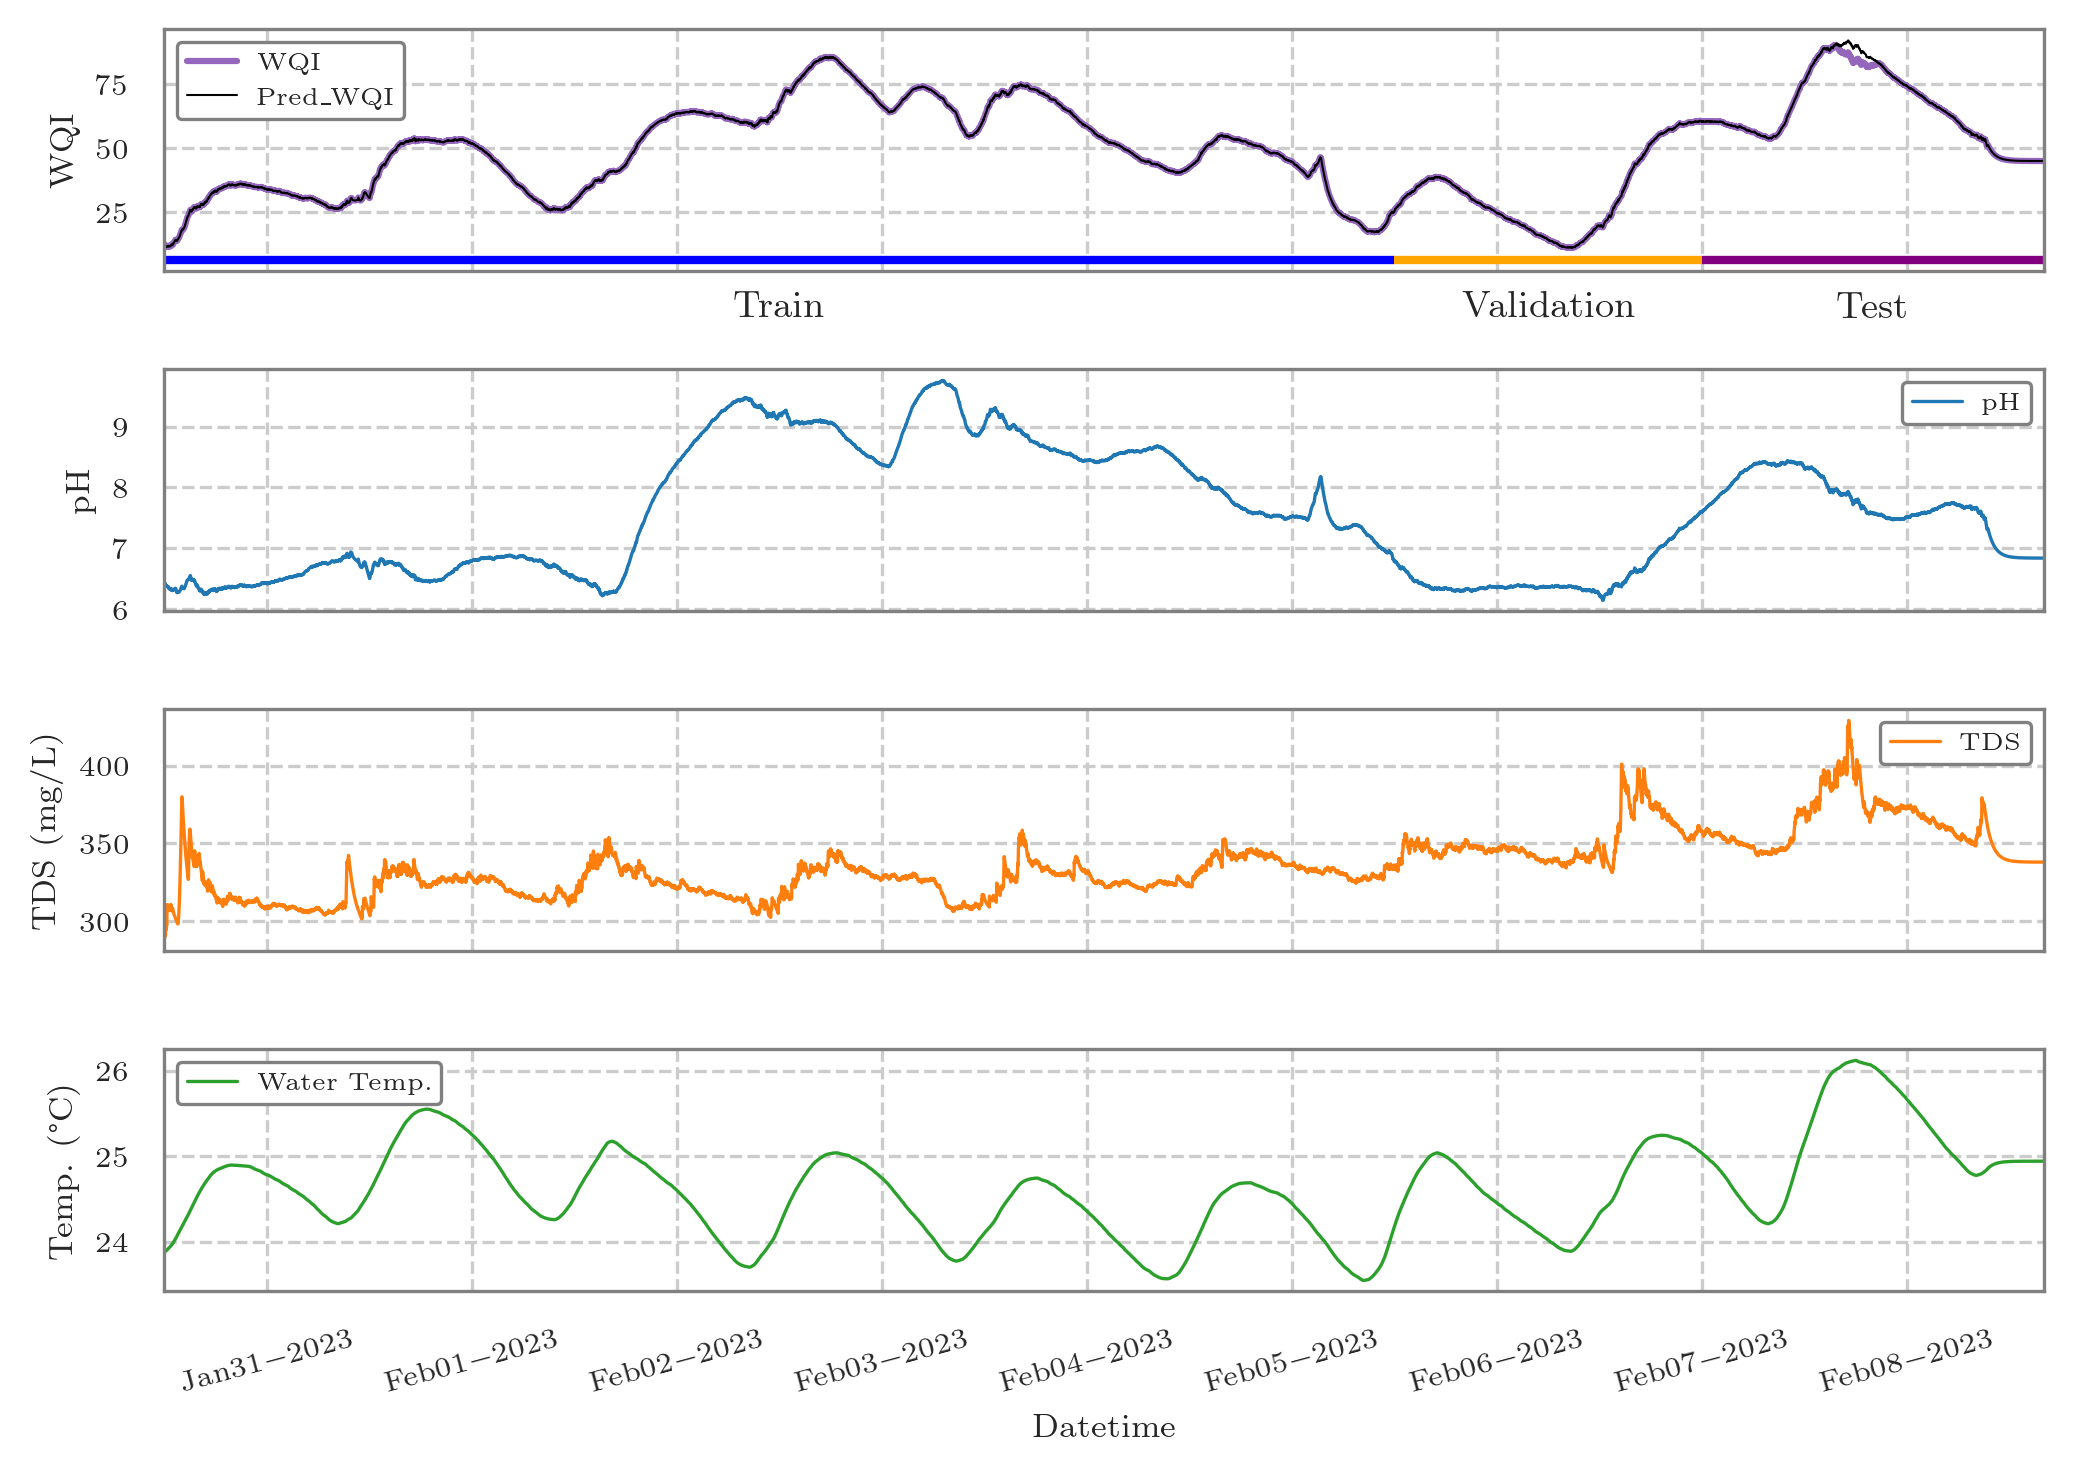

In [8]:
# Set up the figure with 4 subplots (stacked vertically)
fig, axs = plt.subplots(4, 1, figsize=(7, 5), sharex=True)  # sharex=True to share the datetime axis

predict_symb_01 = lambda x: 17.3102* x[:, 0] + 24.5182 * x[:, 1] - 684.922

yData_pred = predict_symb_01(xData)

# Water Quality Index (WQI) - Moved to the first subplot (axs[0])
axs[0].plot(date, yData , color='tab:purple', linewidth=1.5, label='WQI')
axs[0].plot(date, yData_pred , color='k', linewidth=0.5, label='Pred_WQI')
axs[0].set_ylabel('WQI')
axs[0].set_xlim((date[0], date[-1]))

# Add horizontal line bars to indicate Train, Validation, and Test splits
WQI = df_WQ['WA_WQI'].values
y_line = min(yData ) - 5  # Position of the line slightly above the max WQI


# Add horizontal line segments with labels
axs[0].hlines(y_line, date[0], date[n_train], colors='blue', linewidth=2)#, label='Train')
axs[0].hlines(y_line, date[n_train], date[n_train + n_val], colors='orange', linewidth=2)#, label='Validation')
axs[0].hlines(y_line, date[n_train + n_val], date[-1], colors='purple', linewidth=2)#, label='Test')

# Positioning the labels in the middle of each segment
axs[0].text(date[n_train // 2], y_line - 25 , 'Train', ha='center', va='bottom', fontsize=9)
axs[0].text(date[n_train + n_val // 2], y_line - 25, 'Validation', ha='center', va='bottom', fontsize=9)
axs[0].text(date[n_train + n_val + n_test // 2], y_line - 25, 'Test', ha='center', va='bottom', fontsize=9)

axs[0].grid(True)
axs[0].legend()

# Water pH
axs[1].plot(date, df_WQ['water_pH'], color='tab:blue', linewidth=0.8, label='pH')
axs[1].set_ylabel('pH')
axs[1].grid(True)
axs[1].legend()

# TDS (Total Dissolved Solids)
axs[2].plot(date, df_WQ['TDS'], color='tab:orange', linewidth=0.8, label='TDS')
axs[2].set_ylabel('TDS (mg/L)')
axs[2].grid(True)
axs[2].legend()

# Water Temperature
axs[3].plot(date, df_WQ['water_temp'], color='tab:green', linewidth=0.8, label='Water Temp.')
axs[3].set_ylabel('Temp. (°C)')
axs[3].set_xlabel('Datetime')
axs[3].grid(True)
axs[3].legend()

# Format x-tick labels in the last subplot
axs[3].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b%d-%Y'))
axs[3].tick_params(axis='x', rotation=15)

# Save to Results directory
results_fig_dir = PROJECT_ROOT/Path('results/figures')

# Adjust layout to prevent overlap
fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'Dataset_Split.pdf'
fig.savefig(fig_path, format='pdf')

# Show the plot
plt.show()

In [9]:
# Convert input features to torch tensors
train_input = torch.tensor(x_train, dtype=torch.float32)
val_input   = torch.tensor(x_val, dtype=torch.float32)
test_input  = torch.tensor(x_test, dtype=torch.float32)

# Convert output labels to torch tensors (as column vectors)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32)
val_label   = torch.tensor(y_val[:, None], dtype=torch.float32)
test_label  = torch.tensor(y_test[:, None], dtype=torch.float32)

dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

dataset_train_val = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': val_input,
    'test_label': val_label
}

In [10]:
# Create KAN
model = KAN(width=[3,3,1], grid=10, k=3, seed = 42, device=device)

# Train KAN
results = model.fit(dataset_train_val,
                      opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss()) 

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.29e-01 | test_loss: 2.80e-01 | reg: 2.90e+01 | : 100%|█| 50/50 [00:42<00:00,  1.17it

saving model version 0.1


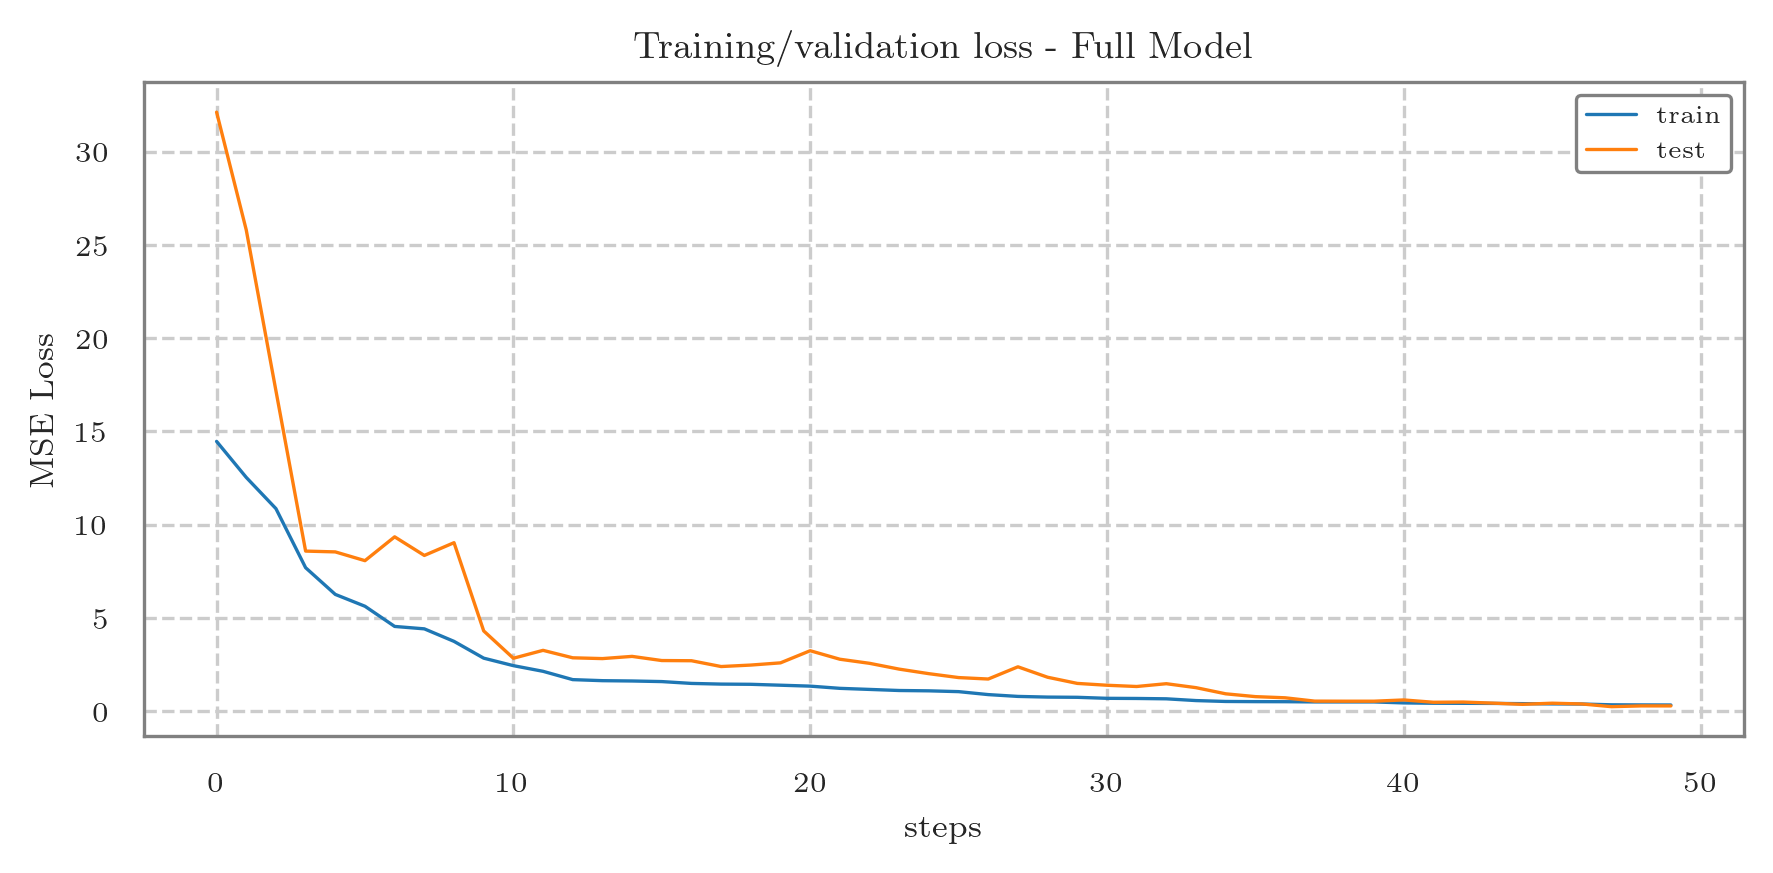

In [ ]:
train_loss = results['train_loss']
test_loss = results['test_loss']

fig,ax = plt.subplots(figsize=(6,3))

ax.plot(train_loss, linewidth = 0.8,label = 'train')
ax.plot(test_loss, linewidth = 0.8,label = 'test')
ax.set_xlabel('steps')
ax.set_ylabel('MSE Loss')
ax.set_title('Training/validation loss - Full Model')
ax.legend()

# Adjust layout to prevent overlap
fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'Train_Val_Loss-Full-Model.pdf'
fig.savefig(fig_path, format='pdf')

plt.show()

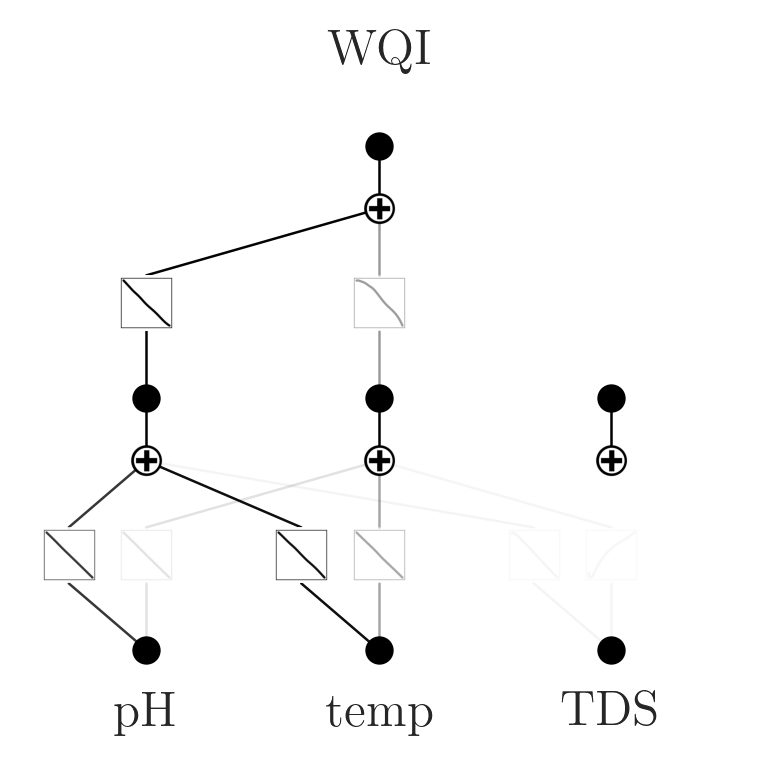

In [28]:
# model(dataset['train_input'])
model.plot( in_vars=['pH', 'temp', 'TDS'], out_vars=['WQI'], scale=0.3)#, title = 'Original model')

# Access the most recent active figure
fig = plt.gcf()

# Save to file
# fig.savefig("results/figures/kan_model_structure.png", dpi=300, bbox_inches='tight')

# Adjust layout to prevent overlap
# fig.tight_layout()

# Save the figure
fig_path = results_fig_dir / 'kan_model_full.pdf'
fig.savefig(fig_path, format='pdf', bbox_inches='tight', dpi=600)
